<a href="https://colab.research.google.com/github/daniel-hain/workshop_london_nlp_2023/blob/main/notebooks/workshop_sbert_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
# Installing sentence transformer libary to work with SBERT
!pip install -qU transformers sentence-transformers
!pip install gradio -q

In [154]:
# standard stuff
import pandas as pd
import seaborn as sns

# Stuff we will need later
import os
import csv
import time

# Semantic Similarity


## Introduction

Semantic search seeks to improve search accuracy by understanding the content of the search query. In contrast to traditional search engines, which only find documents based on lexical matches, semantic search can also find synonyms.

In fact, this type of search makes browsing more complete by understanding almost exactly what the user is trying to ask, instead of simply matching keywords to pages. The idea behind semantic search is to embed all entries in your corpus, which can be sentences, paragraphs, or documents, into a vector space.

At search time, the query is embedded into the same vector space and the closest embedding from your corpus is found. These entries should have a high semantic overlap with the query.

## Types of search: Symmetric vs. Asymmetric Semantic Search
A critical distinction for your setup is symmetric vs. asymmetric semantic search:

For **symmetric** semantic search your query and the entries in your corpus are of about the same length and have the same amount of content. An example would be searching for similar questions: Your query could for example be “How to learn Python online?” and you want to find an entry like “How to learn Python on the web?”. For symmetric tasks, you could potentially flip the query and the entries in your corpus.

For **asymmetric** semantic search, you usually have a short query (like a question or some keywords) and you want to find a longer paragraph answering the query. An example would be a query like “What is Python” and you wand to find the paragraph “Python is an interpreted, high-level and general-purpose programming language. Python’s design philosophy …”. For asymmetric tasks, flipping the query and the entries in your corpus usually does not make sense.

# Toy example

A simple example of a couple of sentences. Imagine our task is to calculate semantic similarity between them:

In [155]:
sentences = ["The moon looked like a giant pumpkin in the sky",
             "She tried to teach her cat how to speak French, but it was not very successful",
             "The chef's secret ingredient was not what anyone expected",
             "He always carried a spoon with him, just in case he needed to eat something",
             "The trees whispered secrets to each other in the wind"]

## Cross- vs Bi-Encoder

![](https://raw.githubusercontent.com/UKPLab/sentence-transformers/master/docs/img/Bi_vs_Cross-Encoder.png)

* **Bi-Encoders** produce for a given sentence a sentence embedding. We pass to a BERT independently the sentences A and B, which result in the sentence embeddings u and v. These sentence embedding can then be compared using cosine similarity:
* In contrast, for a **Cross-Encoder**, we pass both sentences simultaneously to the Transformer network. It produces than an output value between 0 and 1 indicating the similarity of the input sentence pair:

## BERT (Cross-Encoder)

Lets we'll take a look at how we can use transformer models (like BERT) to create sentence vectors for calculating similarity. Let's start by defining a few example sentences.

In [156]:
from transformers import AutoTokenizer, AutoModel # Transformer library
import torch # Deep learning framework

if not torch.cuda.is_available():
  print("Warning: No GPU detected. Processing will be slow. Please add a GPU to this notebook")

Initialize our HF transformer model and tokenizer - using a pretrained BERT model.

In [33]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens') # Load dokenizer
model = AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens') # Load model

Tokenize all of our sentences.

In [34]:
tokens = tokenizer(sentences,
                   max_length=128,
                   truncation=True,
                   padding='max_length',
                   return_tensors='pt')

In [35]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [36]:
tokens['input_ids'][0]

tensor([  101,  1996,  4231,  2246,  2066,  1037,  5016, 25730,  1999,  1996,
         3712,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

Process our tokenized tensors through the model.

In [37]:
outputs = model(**tokens)
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

Here we can see the final embedding layer, *last_hidden_state*.

In [38]:
embeddings = outputs.last_hidden_state
embeddings[0] #Take a look at the embedding

tensor([[-0.9237,  0.6331, -0.6292,  ..., -0.1519,  0.7163,  0.1171],
        [-0.7028,  0.7832, -0.7461,  ..., -0.0606,  0.6382, -0.4263],
        [-0.1517,  0.7947, -0.4016,  ..., -0.5171,  0.7831,  0.0564],
        ...,
        [-0.5595,  0.4359, -0.3003,  ...,  0.1321,  0.4995,  0.0448],
        [-0.3713,  0.4267, -0.2508,  ...,  0.0713,  0.5095,  0.0921],
        [-0.3553,  0.4556, -0.1967,  ...,  0.0943,  0.4764,  0.1074]],
       grad_fn=<SelectBackward0>)

In [39]:
embeddings[0].shape

torch.Size([128, 768])

Here we have our vectors of length *768*, but we see that these are not *sentence vectors* because we have a vector representation for each token in our sequence (128 in total). We need to perform a mean pooling operation to create the sentence vector.

The first thing we do is multiply each value in our `embeddings` tensor by its respective `attention_mask` value. The `attention_mask` contains **1s** where we have 'real tokens' (eg not padding tokens), and 0s elsewhere - so this operation allows us to ignore non-real tokens.

In [40]:
mask = tokens['attention_mask'].unsqueeze(-1).expand(embeddings.size()).float()
mask.shape

torch.Size([5, 128, 768])

In [41]:
mask[0]

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Now we have a masking array that has an equal shape to our output `embeddings` - we multiply those together to apply the masking operation on our outputs.

In [42]:
masked_embeddings = embeddings * mask # Multiply embeddings with mask
masked_embeddings[0]

tensor([[-0.9237,  0.6331, -0.6292,  ..., -0.1519,  0.7163,  0.1171],
        [-0.7028,  0.7832, -0.7461,  ..., -0.0606,  0.6382, -0.4263],
        [-0.1517,  0.7947, -0.4016,  ..., -0.5171,  0.7831,  0.0564],
        ...,
        [-0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       grad_fn=<SelectBackward0>)

Sum the remaining embeddings along axis 1 to get a total value in each of our 768 values.

In [43]:
summed = torch.sum(masked_embeddings, 1)
summed.shape

torch.Size([5, 768])

Next, we count the number of values that should be given attention in each position of the tensor (+1 for real tokens, +0 for non-real).

In [44]:
counted = torch.clamp(mask.sum(1), min=1e-9)
counted.shape

torch.Size([5, 768])

Finally, we get our mean-pooled values as the `summed` embeddings divided by the number of values that should be given attention, `counted`.

In [45]:
mean_pooled = summed / counted
mean_pooled.shape

torch.Size([5, 768])

Now we have our sentence vectors, we can calculate the cosine similarity between each.

In [46]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [47]:
# convert to numpy array from torch tensor
mean_pooled = mean_pooled.detach().numpy()

# calculate similarities (will store in array)
scores = np.zeros((mean_pooled.shape[0], mean_pooled.shape[0]))
for i in range(mean_pooled.shape[0]):
    scores[i, :] = cosine_similarity(
        [mean_pooled[i]],
        mean_pooled
    )[0]

In [48]:
scores

array([[1.        , 0.10904796, 0.15862966, 0.18297407, 0.07228525],
       [0.10904796, 1.00000036, 0.57320881, 0.2004101 , 0.32288545],
       [0.15862966, 0.57320881, 1.00000012, 0.29735228, 0.37347689],
       [0.18297407, 0.2004101 , 0.29735228, 1.        , 0.16934036],
       [0.07228525, 0.32288545, 0.37347689, 0.16934037, 1.00000012]])

We can visualize these scores:

In [50]:
sentences

['The moon looked like a giant pumpkin in the sky',
 'She tried to teach her cat how to speak French, but it was not very successful',
 "The chef's secret ingredient was not what anyone expected",
 'He always carried a spoon with him, just in case he needed to eat something',
 'The trees whispered secrets to each other in the wind']

<Axes: >

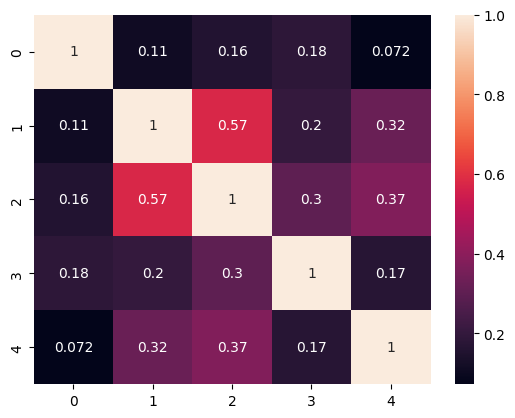

In [49]:
sns.heatmap(scores, annot=True)

## SBERT: sentence-transformers (bi-encoders)

The `sentence-transformers` library allows us to compress all of the above into just a few lines of code.

In [157]:
from sentence_transformers import SentenceTransformer, util
import torch

In [158]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [159]:
device = torch.device("cuda")
model.cuda()

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

We encode the sentences (producing our mean-pooled sentence embeddings) like so:

In [160]:
sentence_embeddings = model.encode(sentences)

And calculate the cosine similarity just like before.

In [161]:
# calculate similarities (will store in array)
scores = np.zeros((sentence_embeddings.shape[0], sentence_embeddings.shape[0]))
for i in range(sentence_embeddings.shape[0]):
    scores[i, :] = cosine_similarity(
        [sentence_embeddings[i]],
        sentence_embeddings
    )[0]

<Axes: >

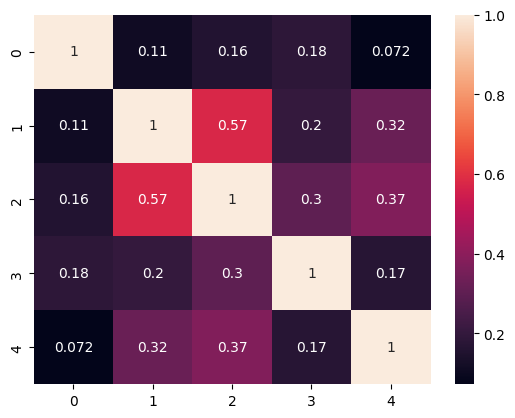

In [162]:
sns.heatmap(scores, annot=True)

Or do some semantic search:

In [163]:
# Query sentences:
queries = ['A man is eating pasta.', 'Someone in a gorilla costume is playing a set of drums.', 'A cheetah chases prey on across a field.']

In [ ]:
# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = min(2, len(sentences))
for query in queries:
    query_embedding = model.encode(query)

    # We use cosine-similarity and torch.topk to find the highest 5 scores
    cos_scores = util.cos_sim(query_embedding, sentence_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop  most similar sentences in corpus:")

    for score, idx in zip(top_results[0], top_results[1]):
        print(sentences[idx], "(Score: {:.4f})".format(score))

In [165]:
new_sentences = [
    "The smell of freshly baked bread filled the air",
    "She danced like nobody was watching, but everyone was",
    "He couldn't believe his luck when he won the lottery",
    "The puppy chewed on the slipper, leaving teeth marks all over it",
    "The train station was bustling with people",
    "She was lost in thought as she gazed out the window",
    "The sun was setting, casting a warm glow over the horizon",
    "He took a deep breath and jumped into the pool",
    "The concert was so loud that she could feel the bass in her chest",
    "The smell of coffee wafted through the air",
    "The book was so engrossing that she lost track of time",
    "The waves crashed against the shore, creating a soothing sound",
    "He couldn't stop laughing at the silly joke",
    "The snow was falling softly, covering everything in a blanket of white",
    "She took a sip of the hot tea, savoring the warmth",
    "The smell of freshly cut grass filled his nostrils",
    "The baby's laughter was contagious",
    "The scent of lavender filled the room",
    "He leaned in for a kiss and she turned away",
    "The wind howled through the trees, making them sway",
    "She opened the door and was greeted by a blast of cold air",
    "The fire crackled in the fireplace, providing a cozy ambiance",
    "He struggled to lift the heavy box, but eventually managed to do it",
    "The stars twinkled in the clear night sky",
    "She ran her fingers through the soft fur of the kitten",
    "The sound of the rain tapping against the window was soothing",
    "He took a bite of the juicy burger and savored the flavor",
    "The chirping of the birds signaled the arrival of spring",
    "The fireworks lit up the night sky, mesmerizing everyone",
    "She closed her eyes and let the warm sun wash over her face",
    "The sound of the ocean was a constant background noise",
    "He walked down the street, taking in the sights and sounds of the city",
    "The scent of pine needles filled the forest",
    "She felt the sand between her toes as she walked along the beach",
    "The children were laughing and playing in the park",
    "The smell of barbecue filled the air, making his mouth water",
    "He wrapped his arms around her and held her close",
    "The sound of the church bells could be heard in the distance",
    "She leaned in and whispered a secret in his ear",
    "The leaves rustled in the wind, creating a calming sound",
    "He sipped on the cold beer and felt his worries slip away",
    "The smell of sunscreen and salt water was a sign of summer",
    "The sound of the violin filled the concert hall",
    "She couldn't believe how beautiful the sunset was",
    "The fresh mountain air was invigorating",
    "He tried to catch the butterfly, but it slipped through his fingers",
    "The sound of the river rushing by was both soothing and invigorating",
    "The birds sang a beautiful melody in the morning",
    "She took a deep breath and blew out the candles",
    "The sound of the saxophone filled the room with a jazzy vibe",
    "The smell of cinnamon and apples was a sign of fall",
    "He looked up at the stars and marveled at their beauty",
    "The sound of the typewriter was a reminder of simpler times"]


In [175]:
corpus_embeddings = model.encode(new_sentences)

In [177]:
# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = min(5, len(new_sentences))
for query in sentences:
    query_embedding = model.encode(query)

    # We use cosine-similarity and torch.topk to find the highest 5 scores
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 5 most similar sentences in corpus:")

    for score, idx in zip(top_results[0], top_results[1]):
        print(new_sentences[idx], "(Score: {:.4f})".format(score))

    """
    # Alternatively, we can also use util.semantic_search to perform cosine similarty + topk
    hits = util.semantic_search(query_embedding, corpus_embeddings, top_k=5)
    hits = hits[0]      #Get the hits for the first query
    for hit in hits:
        print(corpus[hit['corpus_id']], "(Score: {:.4f})".format(hit['score']))
    """





Query: The moon looked like a giant pumpkin in the sky

Top 5 most similar sentences in corpus:
The stars twinkled in the clear night sky (Score: 0.4768)
The fireworks lit up the night sky, mesmerizing everyone (Score: 0.4265)
He looked up at the stars and marveled at their beauty (Score: 0.4123)
He couldn't believe his luck when he won the lottery (Score: 0.3352)
The birds sang a beautiful melody in the morning (Score: 0.3244)




Query: She tried to teach her cat how to speak French, but it was not very successful

Top 5 most similar sentences in corpus:
She was lost in thought as she gazed out the window (Score: 0.5347)
He tried to catch the butterfly, but it slipped through his fingers (Score: 0.5316)
The book was so engrossing that she lost track of time (Score: 0.4991)
The puppy chewed on the slipper, leaving teeth marks all over it (Score: 0.4630)
He leaned in for a kiss and she turned away (Score: 0.4442)




Query: The chef's secret ingredient was not what anyone expected


In [180]:
def query_corpus(query):
  results = []
  query_embedding = model.encode(query)
  cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
  top_results = torch.topk(cos_scores, k=top_k)
  for score, idx in zip(top_results[0], top_results[1]):
    results.append((new_sentences[idx], score))
    output = results[0][0]
    score = float(results[0][1].numpy())
  return output, score

In [181]:
query_corpus('Peter likes kittens and sometimes talks to them')

('She ran her fingers through the soft fur of the kitten', 0.6149277091026306)

In [182]:
import gradio as gr
gr.Interface(fn=query_corpus, inputs=["text"], outputs=["text", "label"]).launch()

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

# Applications

## Semantic Search using SBERT on Quora Questions dataset

* We use the Quora Duplicate Questions dataset, which contains about 500k questions (we only use about 100k):
https://www.quora.com/q/quoradata/First-Quora-Dataset-Release-Question-Pairs
* The main task the dataset is used is to identify duplicated questions.
* As embeddings model, we use the SBERT model 'quora-distilbert-multilingual',
that it aligned for 100 languages. I.e., you can type in a question in various languages and it will return the closest questions in the corpus (questions in the corpus are mainly in English).
* This is largely how we did question-answering in the years before GPT3


In [183]:
model = SentenceTransformer('quora-distilbert-multilingual')

In [184]:
# Set parameters for download
url = "http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv"
dataset_path = "quora_duplicate_questions.tsv"
max_corpus_size = 100000

In [185]:
# Check if the dataset exists. If not, download and extract
# Download dataset if needed
if not os.path.exists(dataset_path):
    print("Download dataset")
    util.http_get(url, dataset_path)

Download dataset


  0%|          | 0.00/58.2M [00:00<?, ?B/s]

In [186]:
# Get all unique sentences from the file
corpus_sentences = set()
with open(dataset_path, encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_MINIMAL)
    for row in reader:
        corpus_sentences.add(row['question1'])
        if len(corpus_sentences) >= max_corpus_size:
            break

        corpus_sentences.add(row['question2'])
        if len(corpus_sentences) >= max_corpus_size:
            break

In [187]:
# Embed the sentences
corpus_sentences = list(corpus_sentences)
print("Encode the corpus. This might take a while")
corpus_embeddings = model.encode(corpus_sentences, show_progress_bar=True, convert_to_tensor=True)

Encode the corpus. This might take a while


Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

In [188]:
###############################
print("Corpus loaded with {} sentences / embeddings".format(len(corpus_sentences)))

Corpus loaded with 100000 sentences / embeddings


In [189]:
# Function that searches the corpus and prints the results
def search(inp_question):
    start_time = time.time()
    question_embedding = model.encode(inp_question, convert_to_tensor=True)
    hits = util.semantic_search(question_embedding, corpus_embeddings)
    end_time = time.time()
    hits = hits[0]  #Get the hits for the first query

    print("Input question:", inp_question)
    print("Results (after {:.3f} seconds):".format(end_time-start_time))
    for hit in hits[0:5]:
        print("\t{:.3f}\t{}".format(hit['score'], corpus_sentences[hit['corpus_id']]))

In [191]:
search("How do i write a really good data science paper?")

Input question: How do i write a really good data science paper?
Results (after 0.020 seconds):
	0.952	What is the best way to get started with data science?
	0.946	What is the best way to learn data science for a beginner?
	0.943	How do I get started in data science?
	0.941	How do I learn Statistics for Data Science from scratch?
	0.939	How do I learn Data Science by “doing it”?


In [ ]:
#German: How can I learn Python online?
search("Wie kann ich online python lernen?")

In [200]:
#Chinese: How can I learn Python online?
search("如何在线学习python")

Input question: 如何在线学习python
Results (after 0.044 seconds):
	0.979	What's the best way to learn python on my own?
	0.977	How do I start learning python web programming from scratch to advanced?
	0.977	What are some of the best ways to learn python?
	0.977	What are some tips for learning python?
	0.960	How do I start learning machine learning and data science using python?


In [201]:
# French: How can I learn data science really fast?
search("comment puis-je apprendre la science des données très rapidement?")

Input question: comment puis-je apprendre la science des données très rapidement?
Results (after 0.029 seconds):
	0.986	How do I learn Data Science by “doing it”?
	0.979	What is the best way to learn data science for a beginner?
	0.968	What is the best way to get started with data science?
	0.964	How do I get started in data science?
	0.960	How can I learn Big Data on my own so that I can apply for a job in that area?


# Example Cordis EU projects

In [202]:
# Load report-data
reports = pd.read_csv('https://github.com/SDS-AAU/SDS-master/raw/master/M2/data/cordis-h2020reports.gz')

In [203]:
reports.head()

,Unnamed: 0,rcn,language,title,teaser,summary,workPerformed,finalResults,lastUpdateDate,country,projectID,projectAcronym,programme,topics,url
0,9073,186435,en,Periodic Reporting for period 1 - PANIPLAST (I...,Polyaniline has historically been one of the m...,Polyaniline has historically been one of the m...,The feasibility study performed in the frame o...,"Based on this study, it is expected that in th...",2018-08-24 11:56:13,NaN,683373.0,PANIPLAST,H2020-EU.2.3.1.;H2020-EU.2.1.2.,NMP-25-2015-1,http://www.stilz-chimie.com
1,8224,203368,en,Periodic Reporting for period 1 - X5 bitworker...,Problem/issue: Increasing digitalisation enabl...,Problem/issue: Increasing digitalisation enabl...,Potential partner companies for distribution a...,The core purpose of X5 is to provide solutions...,2018-08-28 17:16:17,NaN,745114.0,X5 bitworker,H2020-EU.2.1.1.;H2020-EU.2.3.1.,SMEInst-01-2016-2017,https://www.x-net.at/explore-en/x5-bitworker
2,2318,251560,en,Periodic Reporting for period 1 - INTEND (INte...,"At a time of public budget constraints, major ...","At a time of public budget constraints, major ...","The conceptual path that INTEND followed, is d...",INTEND impacted on improving the competitivene...,2019-04-09 20:26:26,NaN,769638.0,INTEND,H2020-EU.3.4.,MG-8-7-2017,http://www.intend-project.eu
3,5580,247827,en,Periodic Reporting for period 1 - ECOBREW (Ne...,Espresso coffee has always been closely associ...,Espresso coffee has always been closely associ...,IBERITAL has accomplished the following activi...,"""IBERITAL expects to launch the new healthy an...",2019-02-14 12:22:34,NaN,651039.0,ECOBREW,H2020-EU.2.3.1.;H2020-EU.3.2.,SFS-08-2014-1,http://www.iberital.com/
4,6227,242620,en,Periodic Reporting for period 1 - PLEIADES (Pr...,The primary industrial objective of the PLEIAD...,The primary industrial objective of the PLEIAD...,The project successfully completed Requirement...,PLEIADES is working towards two main objective...,2018-11-30 09:44:59,NaN,715775.0,PLEIADES,H2020-EU.3.4.5.5.,JTI-CS2-2015-CFP02-ENG-03-01,http://www.pleiades-cleansky.eu/
